# Task 02: Exploratory Data Analysis (Part 2)

## Lexical Analysis (Word Level)

### Load Dataset

In [15]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoTokenizer 
from wordcloud import WordCloud

train_path = Path("../data/processed/pcl_task1_train.csv")
dev_path = Path("../data/processed/pcl_task1_dev.csv")

train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)

(8375, 7) (2094, 7)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshuakilla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,par_id,art_id,keyword,country_code,text,label_0to4,label_bin
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0,0


### N-gram analysis

In [16]:
def top_ngrams(texts, n=2, k=20, is_df=False):
    # Stop words added back to see how sentence is constructed in higher n-grams
    stop_words = None if n > 2 else "english"
    min_df = 3 if n > 2 else 5

    vec = CountVectorizer(ngram_range=(n,n), stop_words=stop_words, min_df=min_df)
    X = vec.fit_transform(texts)
    counts = X.sum(axis=0).A1
    vocab = vec.get_feature_names_out()
    if is_df:
        df = pd.DataFrame({"ngram": vocab, "count": counts})
        return df.sort_values("count", ascending=False).head(k)
    return sorted(zip(vocab, counts), key=lambda x: -x[1])[:k]

def diff_ngrams(pos_texts, neg_texts, n=2, k=20, normalize=False, both=False):
    stop_words = None if n > 2 else "english"
    min_df = 3 if n > 2 else 5

    vec = CountVectorizer(ngram_range=(n,n), stop_words=stop_words, min_df=min_df)
    X = vec.fit_transform(pd.concat([pos_texts, neg_texts]))
    vocab = vec.get_feature_names_out()

    pos_counts = X[:len(pos_texts)].sum(axis=0).A1
    neg_counts = X[len(pos_texts):].sum(axis=0).A1

    if normalize:
        # if data is unbalanced
        # P(word | PCL) / P(word | non-PCL)   
            # with Laplace smoothing
        pos_freq = (pos_counts + 1) / (pos_counts.sum() + len(vocab))
        neg_freq = (neg_counts + 1) / (neg_counts.sum() + len(vocab))
        score = pos_freq / neg_freq
    else:
        # raw ratio
        score = (pos_counts + 1) / (neg_counts + 1)

    df = pd.DataFrame({"ngram": vocab, "ratio": score}).sort_values("ratio", ascending=False)

    if both:
        return df.head(k), df.tail(k).sort_values("ratio", ascending=True)
    return df.head(k)

def plot_top_ngrams(train_df, n=2, k=20, normalize=False):
    pos = train_df.loc[train_df.label_bin==1, "text"]
    neg = train_df.loc[train_df.label_bin==0, "text"]
    name = "Unigrams" if n==1 else "Bigrams" if n==2 else f"{n}-grams"

    top_df, bottom_df = diff_ngrams(pos, neg, n, k, normalize, both=True)
    bottom_df = bottom_df.copy()
    bottom_df["ratio"] = 1 / bottom_df["ratio"]  # invert for readability

    plots = [
        (f"Top PCL {name}", top_ngrams(pos, n, k, True), "count", "count"),
        (f"Top Non-PCL {name}", top_ngrams(neg, n, k, True), "count", "count"),
        (f"{name} Most Indicative of PCL", top_df, "ratio", "Likelihood ratio (higher = stronger association with PCL)"),
        (f"{name} Most Indicative of Non-PCL", bottom_df, "ratio", "Likelihood ratio (higher = stronger association with Non-PCL)"),
    ]

    for title, df, xcol, xlabel in plots:
        plt.figure(figsize=(8,5))   
        sns.barplot(data=df, y="ngram", x=xcol)
        plt.xlabel(xlabel)
        plt.title(title)
        plt.show()

- P(word | PCL) / P(word | non-PCL)   for likelihood ratio to correct class imbalance

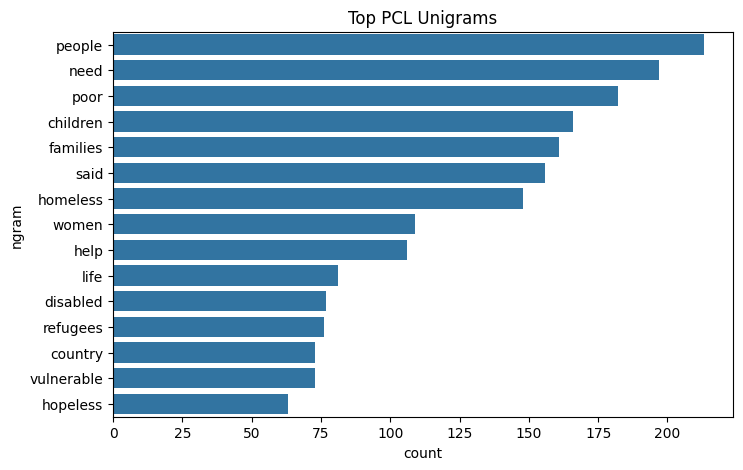

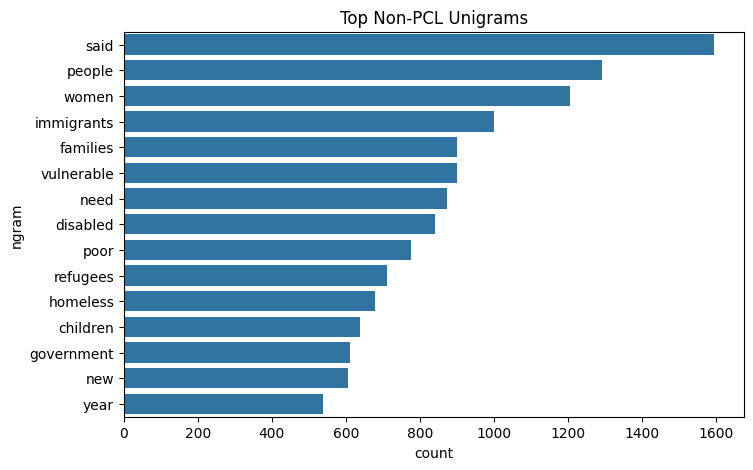

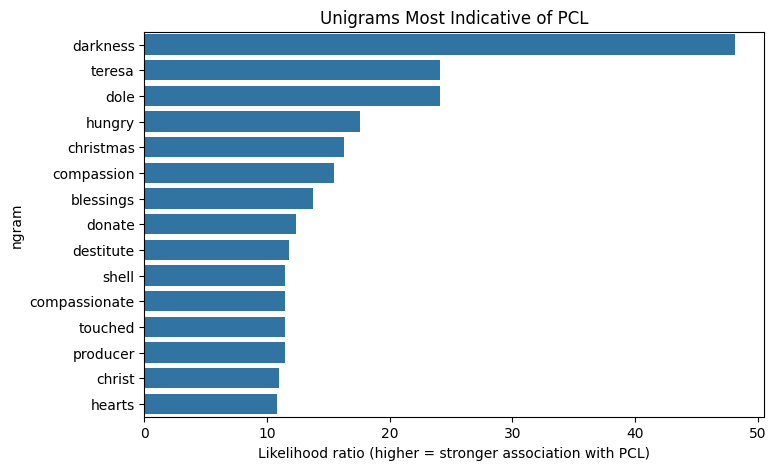

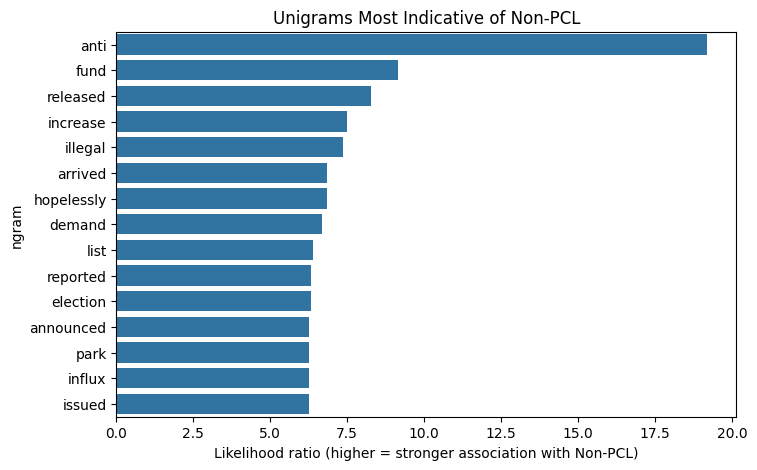

In [17]:
plot_top_ngrams(train_df, n=1, k=15, normalize=True)

- For unigram some very particular words had very strong indication of PCL (10x to 50x more likely)
- darkness is 48x more likely to appear in a PCL paragraph than a non-PCL paragraph

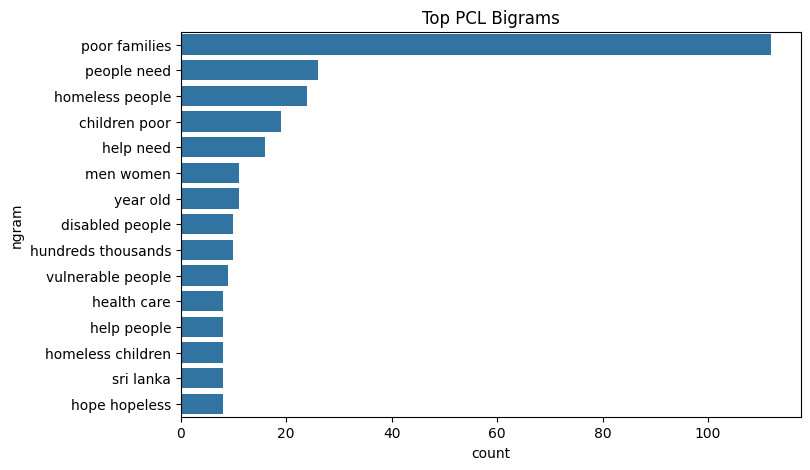

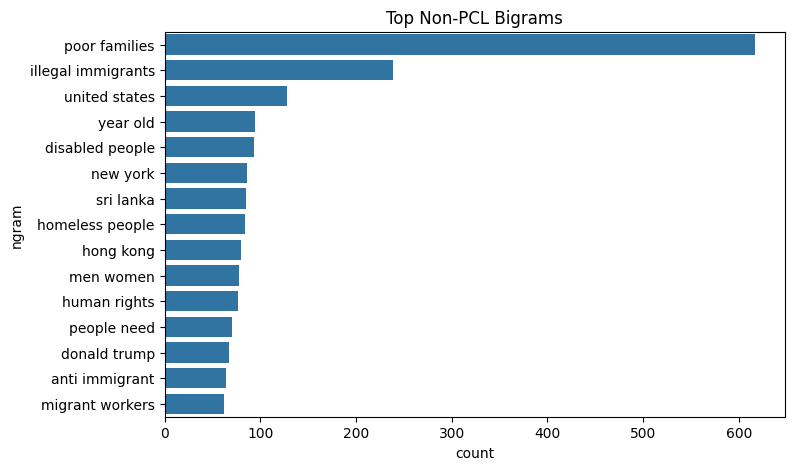

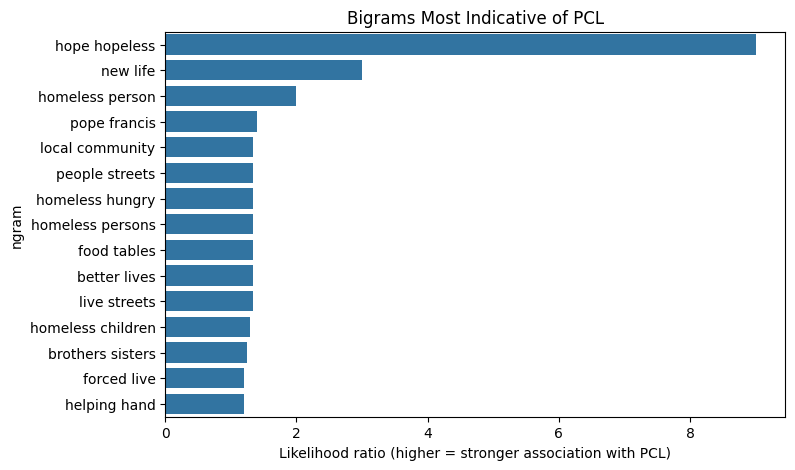

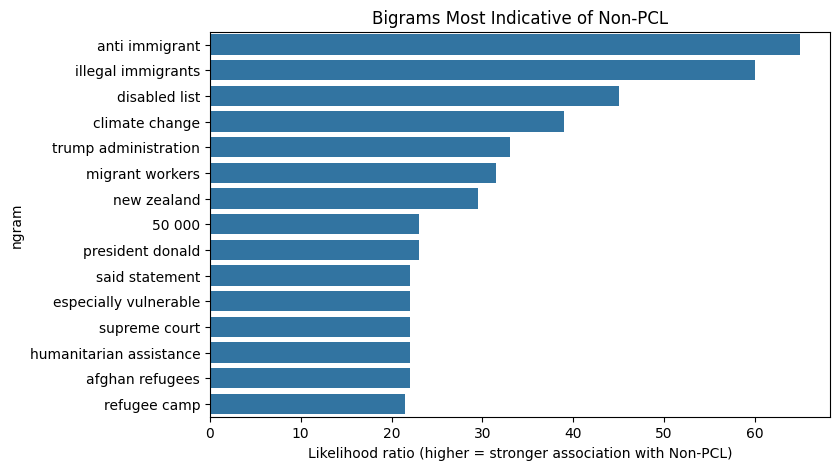

In [18]:
plot_top_ngrams(train_df, n=2, k=15)

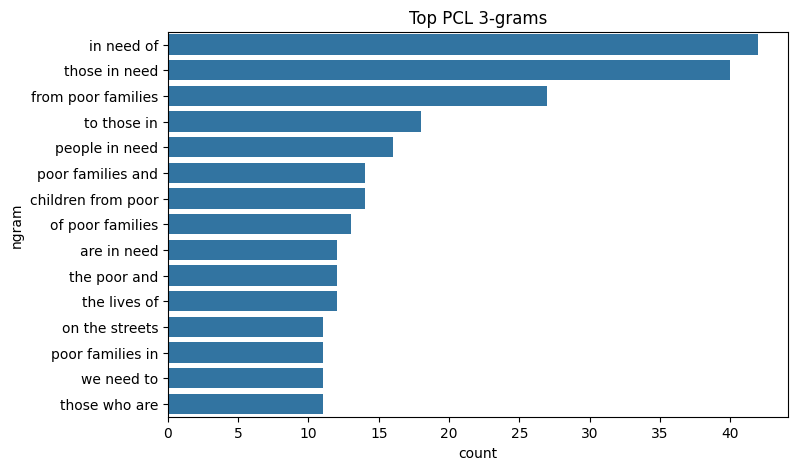

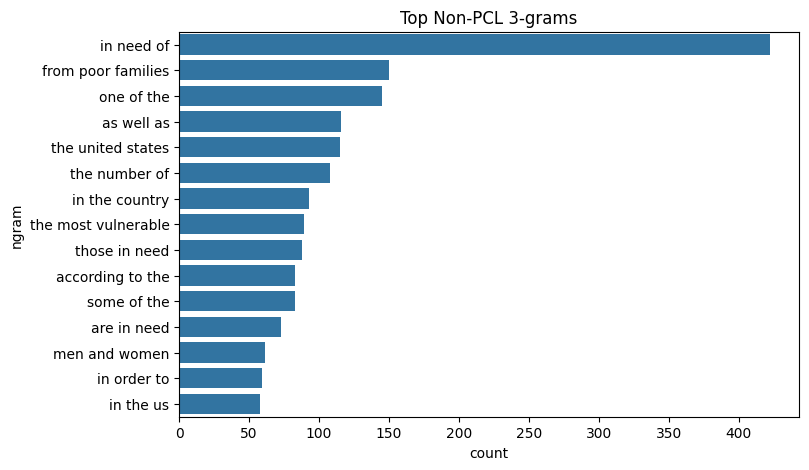

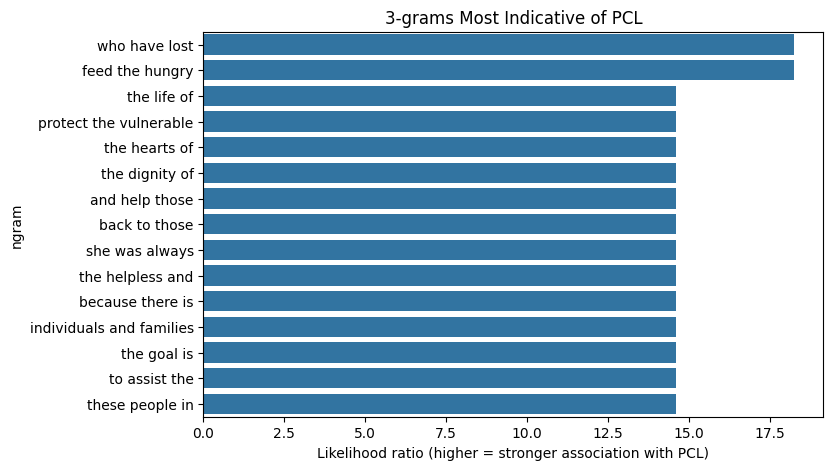

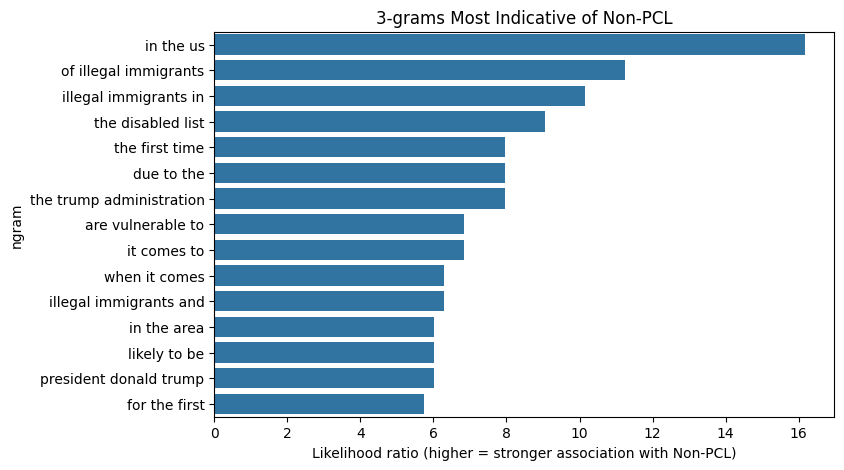

In [19]:
plot_top_ngrams(train_df, n=3, k=15, normalize=True)

### Word clouds & frequency

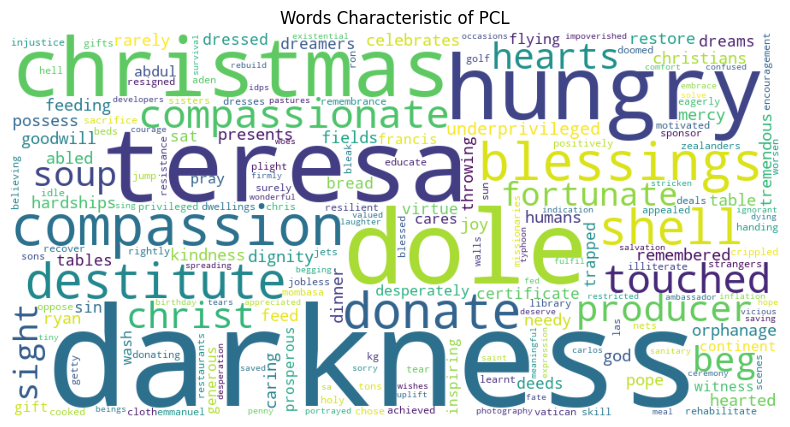

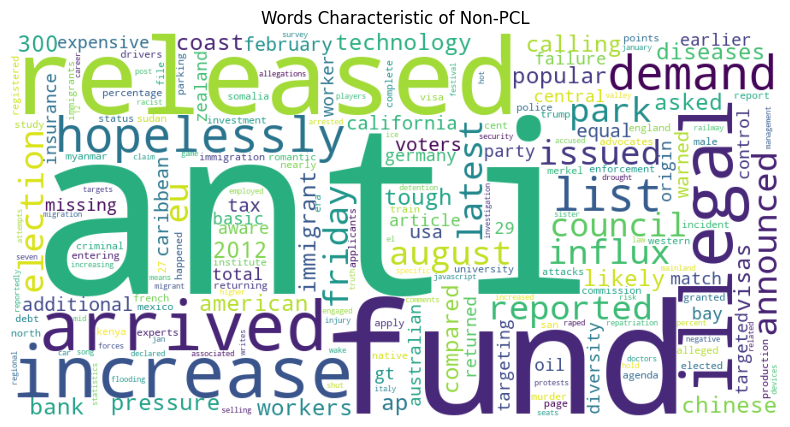

In [20]:
def ratio_weights(pos_texts, neg_texts, top_k=200, normalize=True):
    top_df, _ = diff_ngrams(pos_texts, neg_texts, n=1, k=top_k, normalize=normalize, both=True)
    return dict(zip(top_df["ngram"], top_df["ratio"]))

def ratio_weights_non(pos_texts, neg_texts, top_k=200, normalize=True):
    top_df, _ = diff_ngrams(neg_texts, pos_texts, n=1, k=top_k, normalize=normalize, both=True)
    return dict(zip(top_df["ngram"], top_df["ratio"]))

def plot_weighted_cloud(weights, title):
    wc = WordCloud(width=900, height=450, background_color="white")
    wc.generate_from_frequencies(weights)

    plt.figure(figsize=(10,5))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title)
    plt.show()

pos_texts = train_df.loc[train_df.label_bin==1, "text"]
neg_texts = train_df.loc[train_df.label_bin==0, "text"]

plot_weighted_cloud(ratio_weights(pos_texts, neg_texts), "Words Characteristic of PCL")
plot_weighted_cloud(ratio_weights_non(pos_texts, neg_texts), "Words Characteristic of Non-PCL")

- notice how non-pcl prevelant words are words used in news reporting
- notice how pcl relveant words are emotive words (to evoke feelings not describe facts)
- informational reporting vs sentimental framing

### Stop word density

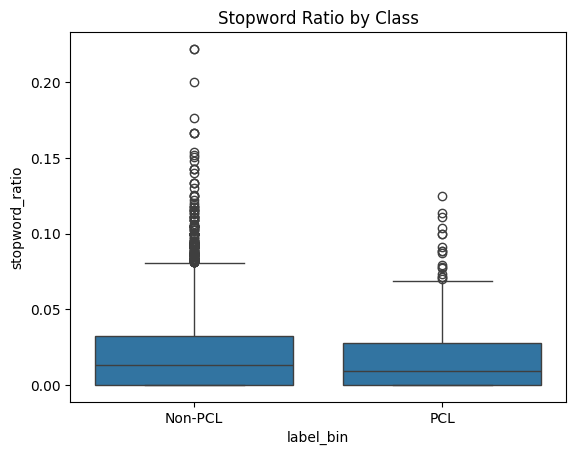

In [21]:
stop_words = set(stopwords.words("english"))
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

def stopword_ratio(text):
    tokens = tokenizer.tokenize(text.lower())
    if len(tokens) == 0:
        return 0
    return sum(t in stop_words for t in tokens) / len(tokens)

train_df["stopword_ratio"] = train_df["text"].apply(stopword_ratio)

sns.boxplot(x="label_bin", y="stopword_ratio", data=train_df)
plt.xticks([0,1], ["Non-PCL", "PCL"])
plt.title("Stopword Ratio by Class")
plt.show()

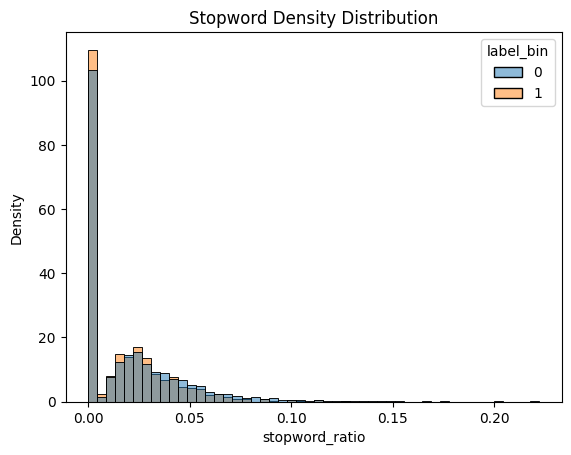

In [22]:
sns.histplot(data=train_df, x="stopword_ratio", hue="label_bin", bins=50, stat="density", common_norm=False)
plt.title("Stopword Density Distribution")
plt.show()

- basically no difference
- this informs us that the difference is not in structural language use but in lexical & pragmatic meaning
- thus the model is very unlikely to try to use this as a shortcut feature - good!
- also shows not much cleanup is requied since stopwords make a small part 